In [8]:
# Import packages.
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from keras.layers import LSTM, Dense
import matplotlib
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import concatenate

In [ ]:
# Read dataset.
df = pd.read_csv("df_subset.csv")

In [4]:
# Drop unneeded columns caused by merging.
df = df[df.columns.drop(list(df.filter(regex='Unnamed')))]

In [5]:
# Add calculated fields.
df["wind_speed"] = np.sqrt(df["u"]**2 + df["v"]**2)
df["wind_dir"] = np.sqrt(df["u"]**2 + df["v"]**2)

In [9]:
# Subset to a specific point.
df_subset = df[df["lat"] == -87.1875]
df_subset = df_subset[df_subset["lon"] == 0]
df_subset = df_subset[df_subset["level"] == 1000]
df_subset["time"] = pd.to_datetime(df_subset["time"])
df_subset = df_subset.drop(columns=["lat", "lon", "level"])

# Split train-test-validation sets
test_real = df_subset[df_subset["time"] >= "2018-01-31"]
val_real = df_subset[(df_subset["time"] >= "2018-01-30") & (df_subset["time"] < "2018-01-31")]
train_real = df_subset[df_subset["time"] < "2018-01-29"]

# Seperate time field.
train_time = train_real.pop("time")
val_time = val_real.pop("time")
test_time = test_real.pop("time")

# Split label data from the rest of the datasets.
train_y_real = train_real.pop("t")
val_y_real = val_real.pop("t")
test_y_real = test_real.pop("t")

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df_subset.drop(columns=["time", "t"]))
train_real = scaler.fit_transform(train_real)
val_real = scaler.fit_transform(val_real)
test_real = scaler.fit_transform(test_real)

# Convert to array
train_y_real = train_y_real.to_numpy()
val_y_real = val_y_real.to_numpy()
test_y_real = test_y_real.to_numpy()

# Reshape for model.
train_real = train_real.reshape((train_real.shape[0], 1, train_real.shape[1]))
val_real = val_real.reshape((val_real.shape[0], 1, val_real.shape[1]))
test_real = test_real.reshape((test_real.shape[0], 1, test_real.shape[1]))

In [10]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss", patience=5, min_delta=0.0003, restore_best_weights=True)

Epoch 1/500
10/10 - 3s - loss: 69492.7891 - val_loss: 64900.3945 - 3s/epoch - 268ms/step
Epoch 2/500
10/10 - 0s - loss: 67484.9141 - val_loss: 62264.4961 - 84ms/epoch - 8ms/step
Epoch 3/500
10/10 - 0s - loss: 64641.8164 - val_loss: 59239.0820 - 72ms/epoch - 7ms/step
Epoch 4/500
10/10 - 0s - loss: 61558.9883 - val_loss: 56323.7188 - 66ms/epoch - 7ms/step
Epoch 5/500
10/10 - 0s - loss: 58644.7734 - val_loss: 53695.9062 - 70ms/epoch - 7ms/step
Epoch 6/500
10/10 - 0s - loss: 56009.4883 - val_loss: 51316.2539 - 65ms/epoch - 6ms/step
Epoch 7/500
10/10 - 0s - loss: 53608.4414 - val_loss: 49120.0117 - 69ms/epoch - 7ms/step
Epoch 8/500
10/10 - 0s - loss: 51385.0781 - val_loss: 47066.0273 - 74ms/epoch - 7ms/step
Epoch 9/500
10/10 - 0s - loss: 49301.4297 - val_loss: 45128.6094 - 69ms/epoch - 7ms/step
Epoch 10/500
10/10 - 0s - loss: 47332.6992 - val_loss: 43290.2617 - 70ms/epoch - 7ms/step
Epoch 11/500
10/10 - 0s - loss: 45461.8672 - val_loss: 41538.3242 - 71ms/epoch - 7ms/step
Epoch 12/500
10/10 

Epoch 94/500
10/10 - 0s - loss: 544.3824 - val_loss: 249.0765 - 85ms/epoch - 8ms/step
Epoch 95/500
10/10 - 0s - loss: 506.6554 - val_loss: 223.8117 - 74ms/epoch - 7ms/step
Epoch 96/500
10/10 - 0s - loss: 471.3725 - val_loss: 200.5843 - 77ms/epoch - 8ms/step
Epoch 97/500
10/10 - 0s - loss: 438.3955 - val_loss: 179.2662 - 70ms/epoch - 7ms/step
Epoch 98/500
10/10 - 0s - loss: 407.5926 - val_loss: 159.7356 - 74ms/epoch - 7ms/step
Epoch 99/500
10/10 - 0s - loss: 378.8385 - val_loss: 141.8763 - 81ms/epoch - 8ms/step
Epoch 100/500
10/10 - 0s - loss: 352.0133 - val_loss: 125.5779 - 88ms/epoch - 9ms/step
Epoch 101/500
10/10 - 0s - loss: 327.0030 - val_loss: 110.7367 - 80ms/epoch - 8ms/step
Epoch 102/500
10/10 - 0s - loss: 303.6996 - val_loss: 97.2531 - 89ms/epoch - 9ms/step
Epoch 103/500
10/10 - 0s - loss: 282.0001 - val_loss: 85.0335 - 75ms/epoch - 7ms/step
Epoch 104/500
10/10 - 0s - loss: 261.8064 - val_loss: 73.9887 - 72ms/epoch - 7ms/step
Epoch 105/500
10/10 - 0s - loss: 243.0259 - val_loss

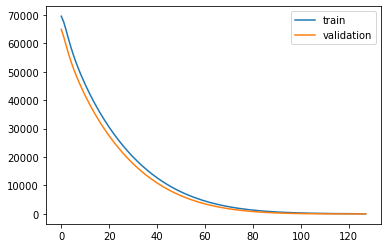

In [11]:
# Create the model
model = tf.keras.models.Sequential()
model.add(LSTM(50, input_shape=(train_real.shape[1], train_real.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

# Fitting
history = model.fit(train_real, train_y_real, epochs=500, batch_size=72, validation_data=(val_real, val_y_real), verbose=2, shuffle=False, callbacks=[early_stopping])

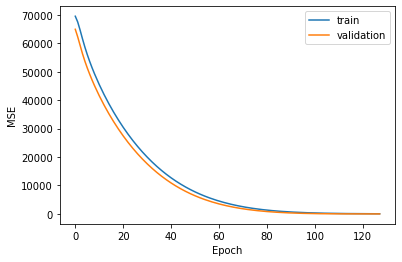

In [22]:
# Plot the training history and save the graph.
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.savefig("Train_History.png")

In [12]:
# Predict the test set and find MAE
yhat = model.predict(test_real)
np.mean(abs(yhat - test_y_real))

1/1 [==============================] - 0s 354ms/step


0.42320783596462835

In [17]:
# Find MSE
np.mean((yhat - test_y_real)**2)

0.21992947103729157